In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from scipy import interpolate
import scipy as sp
from scipy import ndimage,signal

import rawpy
import imageio
import os
import png

from PIL import Image
from skimage.registration import phase_cross_correlation
import cv2
import time

In [89]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
from CQNS_xcorr import *

In this notebook, we are demonstrating the ability to use cross correlation to align a stack of images with subpixel precision to map out changes to images as a function of time. We are particularly using this to image how a MOKE measurement proceeds as we apply shear deformation via a scanned probe system. 

The output of this analysis is an image series of fractional changes relative to a reference image. These would correspond to changes in MOKE signal if the magnetization of a CrI3 sample flips. There are other effects though that we see below, namely that interference fringes may move and thus change the apparent brightness under the SU-8 pillar.

In [93]:
source_path = r'C:/Users/Arthur Barnard/Dropbox (DGG Lab)/UW Lab/Shear of CrI3/2023_05_29_push4/'
fnames=get_image_file_names(source_path)

In [95]:
# average frames for reference image (can set last_frame to first_frame to only access one frame)
first_frame = 0
last_frame = 49
    
ref_image = load_reference_range(fnames,first_frame,last_frame,path_in=source_path)    

C:/Users/Arthur Barnard/Dropbox (DGG Lab)/UW Lab/Shear of CrI3/2023_05_29_push4/ 49


In [96]:
#Define 3 ROIs. First two are for image registration, the last one is for defining the output frames
x1, y1 = 590, 120
x2, y2 = 680, 210
ROI_1 = [x1,y1,x2,y2]

x3, y3 = 870, 240
x4, y4 = 1050, 420
ROI_2 = [x3,y3,x4,y4]

x5, y5 = 400, 200
x6, y6 = 920, 600

ROI_out = [x5,y5,x6,y6]


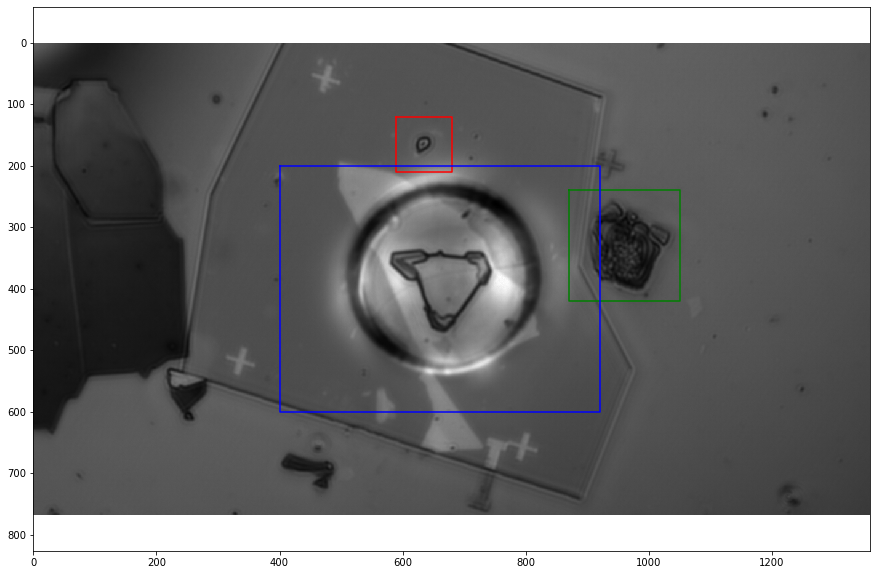

In [97]:
#Display reference and ROIs
fig=plt.figure(figsize=(15,10))
plt.pcolormesh(ref_image,cmap='gray')

plot_ROI_box(ROI_1,'r')
plot_ROI_box(ROI_2,'g')
plot_ROI_box(ROI_out,'b')

plt.axis('equal')
plt.gca().invert_yaxis()
plt.show()

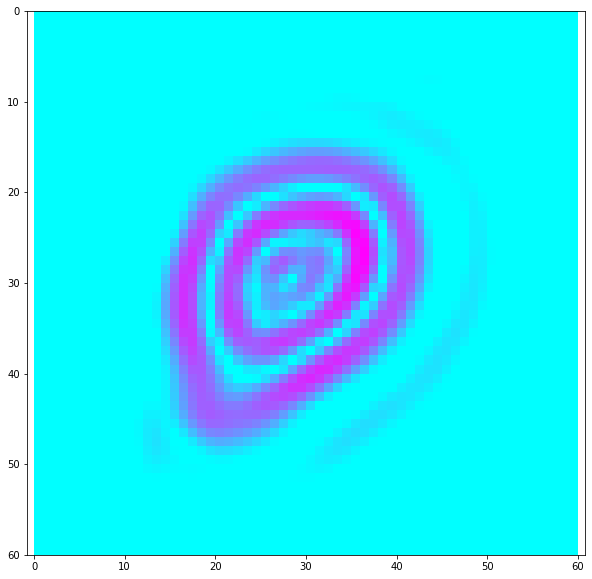

In [8]:
#setting parameters for image reistrations in ROI_1
gauss_blur_ROI_1= 1
threshold_ROI_1 = 10000
pad_ROI_1 = 15

view_image_ROI_edges(ref_image,ROI_1,pad_ROI_1,gauss_blur_ROI_1,threshold_ROI_1)

In [9]:
#carrying out cross-correlation analysis based on parameters defined above
red_N = 10

offsets_ROI_1=offsets_from_xcorr(fnames,ref_image,pad_ROI_1,ROI_1,gauss_blur_ROI_1,
                                 threshold=threshold_ROI_1,path_in=source_path)
stacked_ROI_1 = stack_shifted_reduced_images(fnames,offsets_ROI_1,red_N,path_in=source_path)
_,offsets_post_shift_ROI_1_round1 = iterate_xcorr_shift(stacked_ROI_1,ref_image,
                                                        pad_ROI_1,ROI_1,gauss_blur_ROI_1,threshold_ROI_1,0)
stacked_ROI_1_shifted,offsets_post_shift_ROI_1_round8 = iterate_xcorr_shift(stacked_ROI_1,ref_image,
                                                        pad_ROI_1,ROI_1,gauss_blur_ROI_1,threshold_ROI_1,7)


99


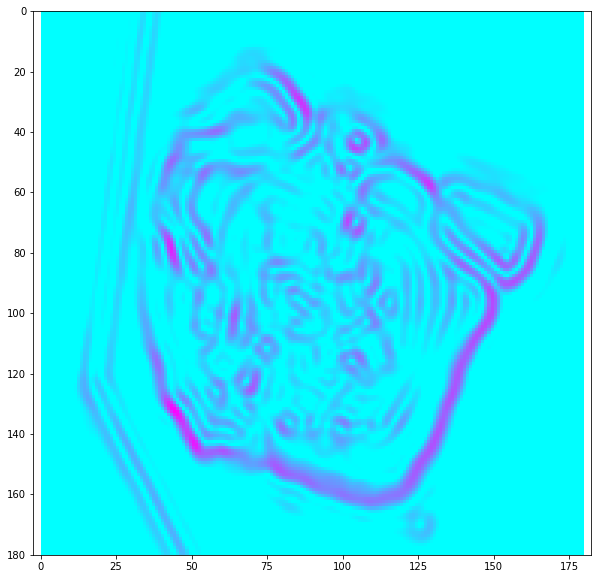

In [10]:
#setting parameters for image reistrations in ROI_2
gauss_blur_ROI_2= 1
threshold_ROI_2 = 10000
pad_ROI_2 = 0

view_image_ROI_edges(ref_image,ROI_2,pad_ROI_2,gauss_blur_ROI_2,threshold_ROI_2)

In [14]:
#carrying out cross-correlation analysis based on parameters defined above
red_N = 10

offsets_ROI_2=offsets_from_xcorr(fnames,ref_image,pad_ROI_2,ROI_2,gauss_blur_ROI_2,
                                 threshold=threshold_ROI_2,path_in=source_path)
stacked_ROI_2 = stack_shifted_reduced_images(fnames,offsets_ROI_2,red_N,path_in=source_path)
_,offsets_post_shift_ROI_2_round1 = iterate_xcorr_shift(stacked_ROI_2,ref_image,
                                                        pad_ROI_1,ROI_2,gauss_blur_ROI_2,threshold_ROI_2,0)
stacked_ROI_2_shifted,offsets_post_shift_ROI_2_round8 = iterate_xcorr_shift(stacked_ROI_2,ref_image,
                                                        pad_ROI_1,ROI_2,gauss_blur_ROI_2,threshold_ROI_2,7)


99


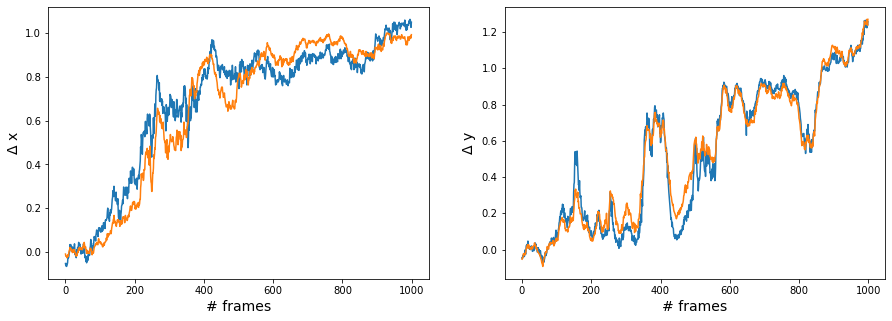

In [102]:
#comparing cross corelation registry between two ROIs
plot_offsets_comparison((offsets_ROI_1,offsets_ROI_2))

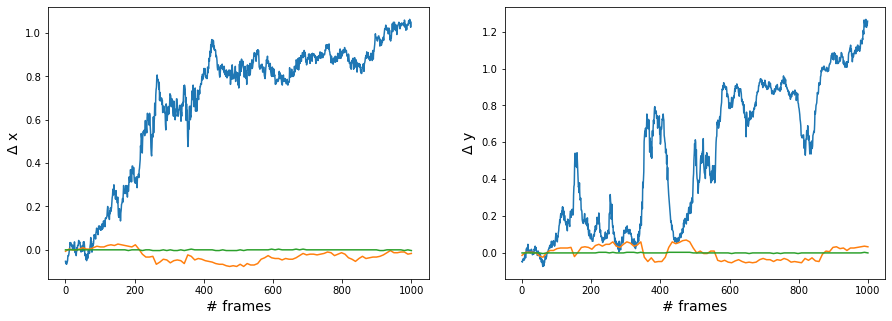

In [103]:
#Seeing how a single pass of frame shifting (orange) and 8 passes of frame shifting compare for ROI_1
plot_offsets_comparison(offsets_ROI_1,(offsets_post_shift_ROI_1_round1,offsets_post_shift_ROI_1_round8))

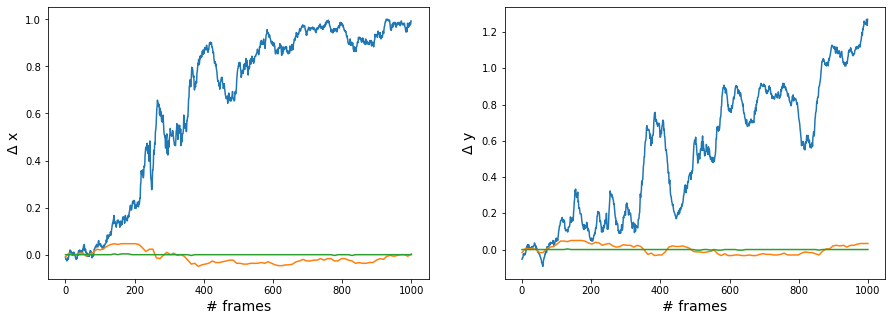

In [104]:
#Seeing how a single pass of frame shifting (orange) and 8 passes of frame shifting compare for ROI_2
plot_offsets_comparison(offsets_ROI_2,(offsets_post_shift_ROI_2_round1,offsets_post_shift_ROI_2_round8))

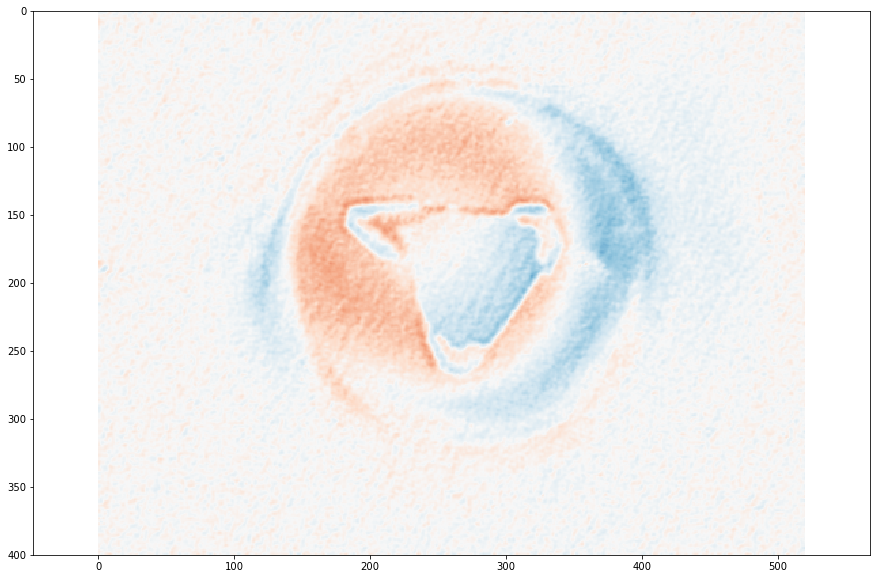

In [61]:
#outputing frame comparison images for ROI_2 after 8 rounds of image shifting

_fname='5_29_offsets_ROI_2_round8'
path_out = source_path[:-1]+'_outputs/'
_color_range=.05

generate_stacked_frames2(_fname, stacked_ROI_2_shifted, ref_image, _color_range, ROI_out=ROI_out,path_out=path_out)

In [ ]:
#ffmpeg -r 60 -i ./2023_05_29_push4_outputs/5_29_offsets_ROI_2_round8_%04d.png -c:v libx264 -pix_fmt yuv420p -crf 8 5_29_offsets_ROI_2_round8.mp4
#ffmpeg -r 60 -i ./2023_05_29_push4_outputs/5_29_offsets_ROI_2_round8_base_%04d.png -c:v libx264 -pix_fmt yuv420p -crf 8 5_29_offsets_ROI_2_round8_base.mp4